In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData
from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.venn_diagram import venn3_diagram

In [2]:
OP_RED = "#FF0420"
plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 144

In [3]:
DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
slugs_param = "'" + "','".join(slugs) + "'"

Loaded 308 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 308 unique slugs.


In [4]:
df = oso.df[['Project ID', 'Project Name', 'Slug: Primary', 'Applicant Type', 'Payout Address', 'Tags']].copy()
df['Voting Link'] = df['Project ID'].apply(lambda x: f"https://vote.optimism.io/retropgf/3/application/{x}")
df['OSO Link'] = df['Slug: Primary'].apply(lambda x: f"https://opensource.observer/project/{x}")
df.rename(columns={'Slug: Primary':'Slug'}, inplace=True)
df.drop(columns=['Project ID'], inplace=True)
df['Tags'] = df['Tags'].apply(lambda x: ", ".join(x))
df.set_index('Slug', inplace=True)
df.head()

Project Name Applicant Type  \
Slug                                               
public-assembly  Public Assembly         PROJECT   
growthepie             growthepie        PROJECT   
aestus-relay         Aestus Relay        PROJECT   
ponder-surveys             Ponder        PROJECT   
ethhub-io              Sassal.eth     INDIVIDUAL   

                                             Payout Address  \
Slug                                                          
public-assembly  0x37bbe5b18C31d565Fc2a2129f427B19754aD70eB   
growthepie       0x700E73d289DE10b6143465E02E6931E6e6a0CA15   
aestus-relay     0xA31895c358D899030A1eB78FeAAdF28C8000CF47   
ponder-surveys   0x81947aadf64cd22ce96999e4c76efb0765839bef   
ethhub-io        0x648aA14e4424e0825A5cE739C8C68610e143FB79   

                                                              Tags  \
Slug                                                                 
public-assembly                                DEVELOPER_ECOSYSTEM   
growthepie                        END_USER_EXPERIENCE_AND_ADOPTION   
aestus-relay                                              OP_STACK   
ponder-surveys   DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_A...   
ethhub-io               END_USER_EXPERIENCE_AND_ADOPTION, OP_STACK   

                                                       Voting Link  \
Slug                                                                 
public-assembly  https://vote.optimism.io/retropgf/3/applicatio...   
growthepie       https://vote.optimism.io/retropgf/3/applicatio...   
aestus-relay     https://vote.optimism.io/retropgf/3/applicatio...   
ponder-surveys   https://vote.optimism.io/retropgf/3/applicatio...   
ethhub-io        https://vote.optimism.io/retropgf/3/applicatio...   

                                                          OSO Link  
Slug                                                                
public-assembly  https://opensource.observer/project/public-ass...  
growthepie          https://opensource.observer/project/growthepie  
aestus-relay      https://opensource.observer/project/aestus-relay  
ponder-surveys   https://opensource.observer/project/ponder-sur...  
ethhub-io            https://opensource.observer/project/ethhub-io

# Presence in past RPGFs

In [5]:
results = execute_query("""
    SELECT c.slug, p.slug, p.name
    FROM collection c
    JOIN collection_projects_project cpp ON c."id" = cpp."collectionId"
    JOIN project p on cpp."projectId" = p."id"
    WHERE c.slug IN ('op-rpgf1', 'op-rpgf2')
    ORDER BY c.slug, p.slug;
""", col_names=False)

cp_mapping = defaultdict(list)
for (collection, project, name) in results:
    cp_mapping[collection].append(project)
cp_mapping['op-rpgf3'] = slugs    

- op-rpgf1: 50 OSS projects
- op-rpgf2: 135 OSS projects
- op-rpgf3: 308 OSS projects


(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

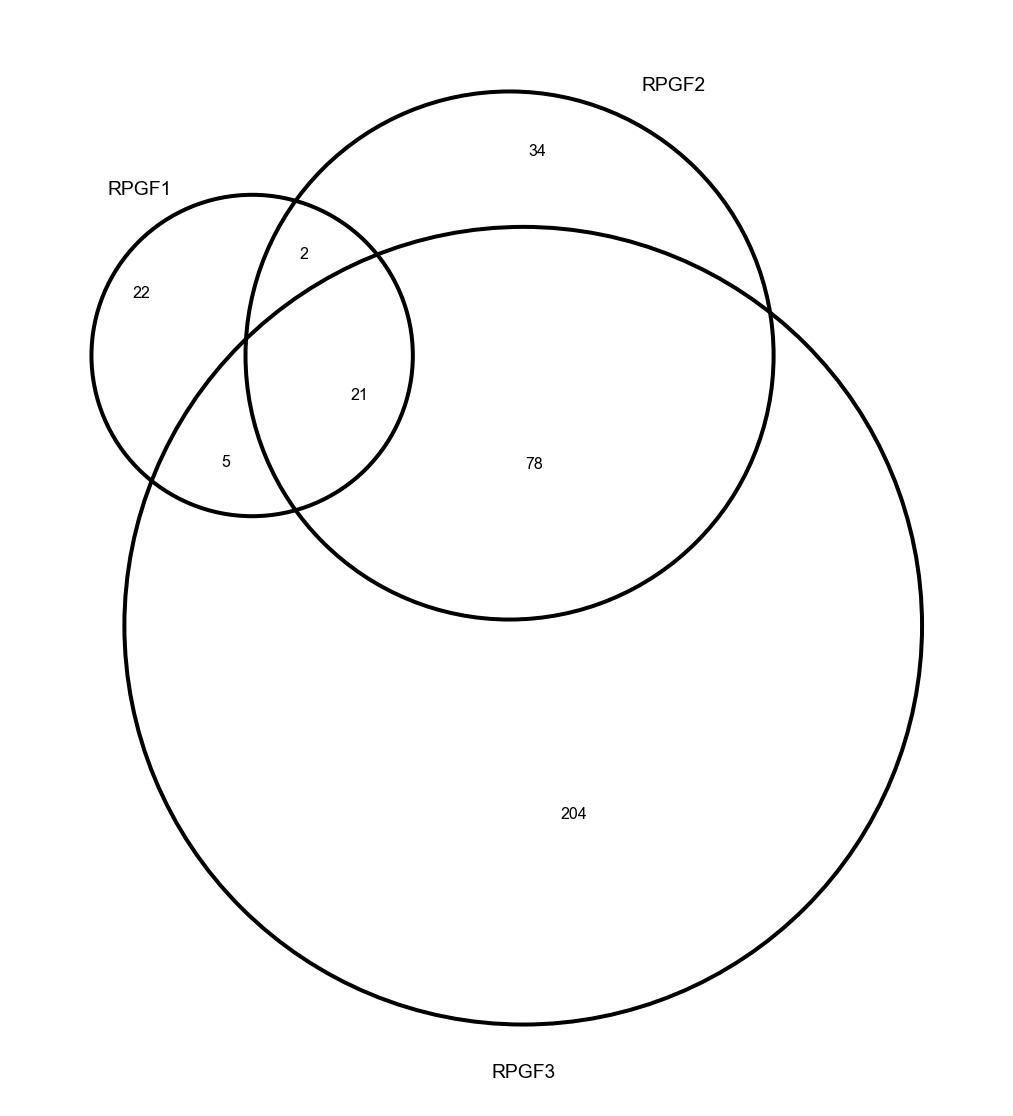

In [6]:
project_sets = []
round_names = []
for collection, project_list in cp_mapping.items():
    round_name = collection.replace("op-","").upper()
    if round_name != 'RPGF3':
        df[round_name] = False
        for slug in project_list:
            if slug in slugs:
                df.at[slug,round_name] = True
    project_sets.append(set(project_list))
    round_names.append(round_name)
    print(f"- {collection}: {len(project_list)} OSS projects")
venn3_diagram(project_sets, round_names)

In [7]:
df[['RPGF1', 'RPGF2']].mean()

RPGF1    0.084416
RPGF2    0.321429
dtype: float64

# Coverage snapshot of RPGF3 projects

In [8]:
def horizontal_bar(series, title=""):    
    fig, ax = plt.subplots(figsize=(10,5), dpi=144)
    sns.barplot(series, orient='h', color=OP_RED, ax=ax)
    ax.bar_label(ax.containers[0], padding=2)
    ax.margins(x=.1)
    ax.set_xticks([])
    sns.despine()
    ax.spines[['bottom']].set_visible(False)
    if title:
        ax.set_title(title, fontweight='bold', fontsize=14, loc='left')

In [9]:
results = execute_query(f"""
    SELECT a.type, COUNT(DISTINCT a.id), COUNT(DISTINCT p.slug)
    FROM project p
    JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN artifact a ON paa."artifactId" = a."id"
    WHERE p.slug IN ({slugs_param}) AND a.namespace <> 'ETHEREUM'
    GROUP BY a.type;
""", col_names=False)

types, artifact_counts, project_counts = zip(*results)

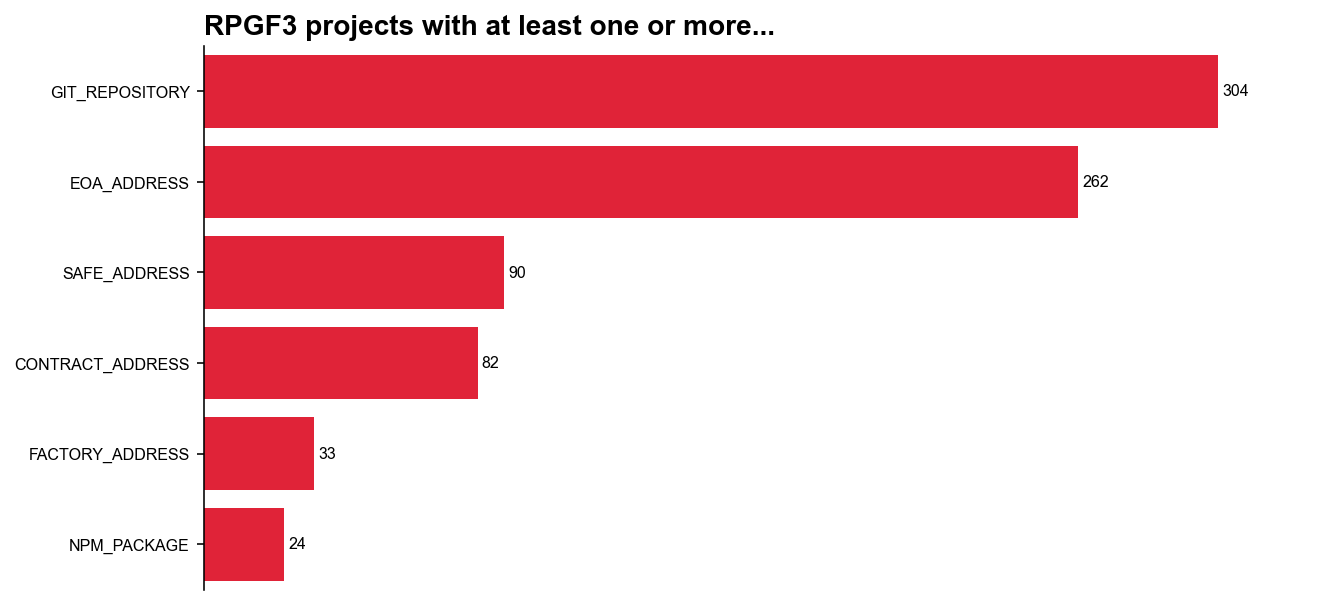

In [10]:
projects_coverage = pd.Series(project_counts, types).sort_values(ascending=False)
horizontal_bar(projects_coverage, "RPGF3 projects with at least one or more...")

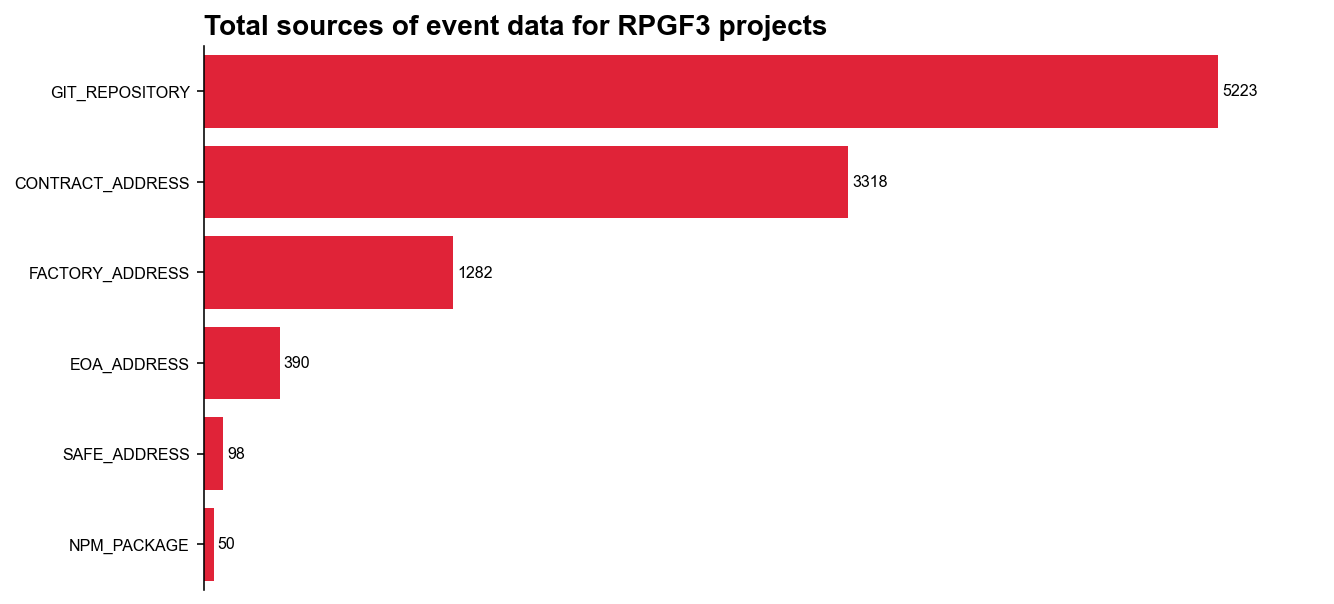

In [11]:
artifacts_coverage = pd.Series(artifact_counts, types).sort_values(ascending=False)
horizontal_bar(artifacts_coverage, "Total sources of event data for RPGF3 projects")

In [12]:
results = execute_query(f"""
    SELECT p.slug, a.type, COUNT(DISTINCT a.id)
    FROM project p
    JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN artifact a ON paa."artifactId" = a."id"
    WHERE p.slug IN ({slugs_param}) AND a.namespace <> 'ETHEREUM'
    GROUP BY p.slug, a.type;
""", col_names=True)

temp_df = pd.DataFrame(results[1:], columns=results[0])
pivot = temp_df.pivot_table(index='slug', columns='type', values='count', aggfunc='sum', fill_value=0)
pivot['# OP Contracts'] = pivot['CONTRACT_ADDRESS'] + pivot['FACTORY_ADDRESS']
pivot.rename(columns={
    'GIT_REPOSITORY': '# GitHub Repos', 
    'NPM_PACKAGE': '# NPM Packages', 
    'SAFE_ADDRESS': '# OP Multisig Wallets'
}, inplace=True)
df_artifact_stats = pivot[[c for c in pivot.columns if "#" in c]]
df_artifact_stats.head(2)

type       # GitHub Repos  # NPM Packages  # OP Multisig Wallets  \
slug                                                               
0x-splits              15               2                      1   
1w3                     3               0                      0   

type       # OP Contracts  
slug                       
0x-splits               4  
1w3                     1

# Activity snapshot of RPGF3 projects

In [13]:
# run query (may take a few minutes)

results = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ({slugs_param})
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    GROUP BY slug, month;
""", col_names=True)

df_devs = pd.DataFrame(results[1:], columns=results[0])
df_devs.head()

slug    month  sum
0        zora  2017-01    0
1       rotki  2020-08    3
2  coordinape  2022-02    3
3       umbra  2021-08    1
4   limechain  2023-10    3

In [14]:
dff_devs = df_devs[(df_devs['month']>='2023-01') & (df_devs['month']<'2023-11')]
avg_active_devs = dff_devs.pivot_table(index='slug', columns='month', values='sum', fill_value=0).mean(axis=1)

In [15]:
contribution_heatmap(
    df_devs[df_devs['month'] > '2014-01'], 
    index_col='slug', 
    column_col='month', 
    value_col='sum', 
    sort_label_method='mean',
    cmap='Reds',
    vmax=10
)

(<Figure size 7080x18180 with 1 Axes>, <AxesSubplot:>)

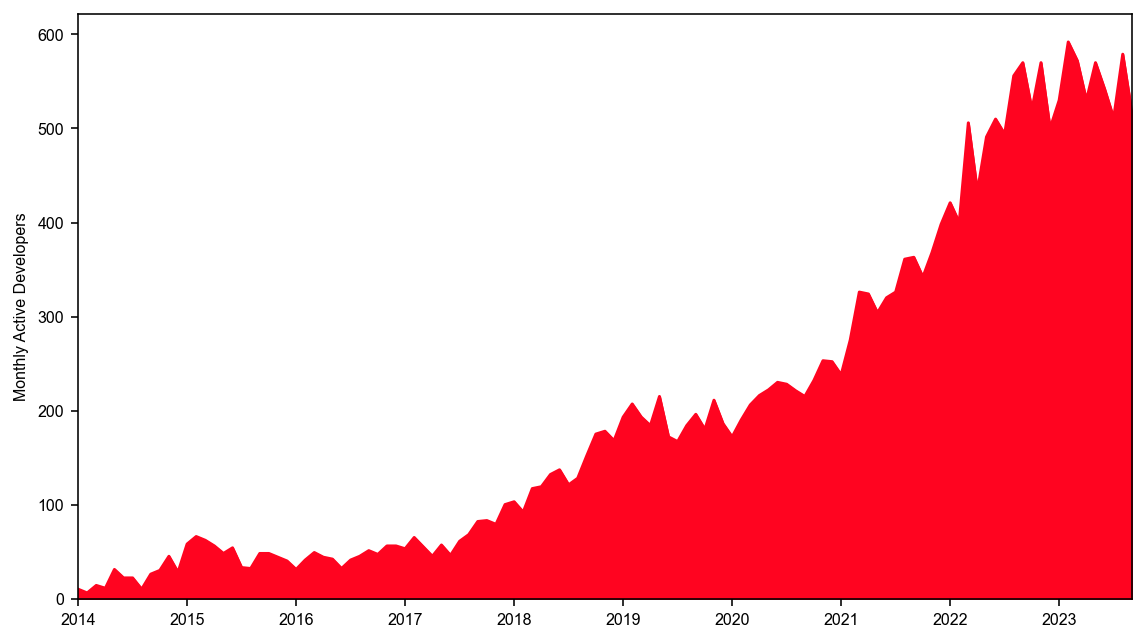

In [16]:
fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
df_devs[(df_devs['month']>='2014-01') & (df_devs['month']<'2023-11')].groupby('month')['sum'].sum().plot(kind='area', ax=ax, color="#FF0420")
ax.set_xlim([0,116])
ax.set_xticks([0,12,24,36,48,60,72,84,96,108])
ax.set_xticklabels(['2014', '2015', '2016', '2017','2018', '2019','2020', '2021', '2022', '2023'])
ax.set_xlabel("")
ax.set_ylabel("Monthly Active Developers")
#ax.get_xlim()
fig.tight_layout()

In [17]:
# run query (may take a few minutes)

results = execute_query(f"""
    WITH Contribs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_contributor"
        FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" IN (
                2, -- PULL_REQUEST_CREATED
                3, -- PULL_REQUEST_MERGED
                4, -- COMMIT_CODE
                6, -- ISSUE_CLOSED
                18 -- ISSUE_CREATED
            )
            AND p.slug IN ({slugs_param})
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_contributor")
    FROM Contribs
    GROUP BY slug, month;
""", col_names=True)

df_contribs = pd.DataFrame(results[1:], columns=results[0])
df_contribs.head()

slug    month  sum
0  cryptozombieshq  2020-12    0
1             zora  2017-01    0
2            rotki  2020-08    5
3       coordinape  2022-02    7
4            umbra  2021-08    2

In [18]:
dff_contribs = df_contribs[(df_contribs['month']>='2023-01') & (df_contribs['month']<'2023-11')]
avg_active_contribs = dff_contribs.pivot_table(index='slug', columns='month', values='sum', fill_value=0).mean(axis=1)

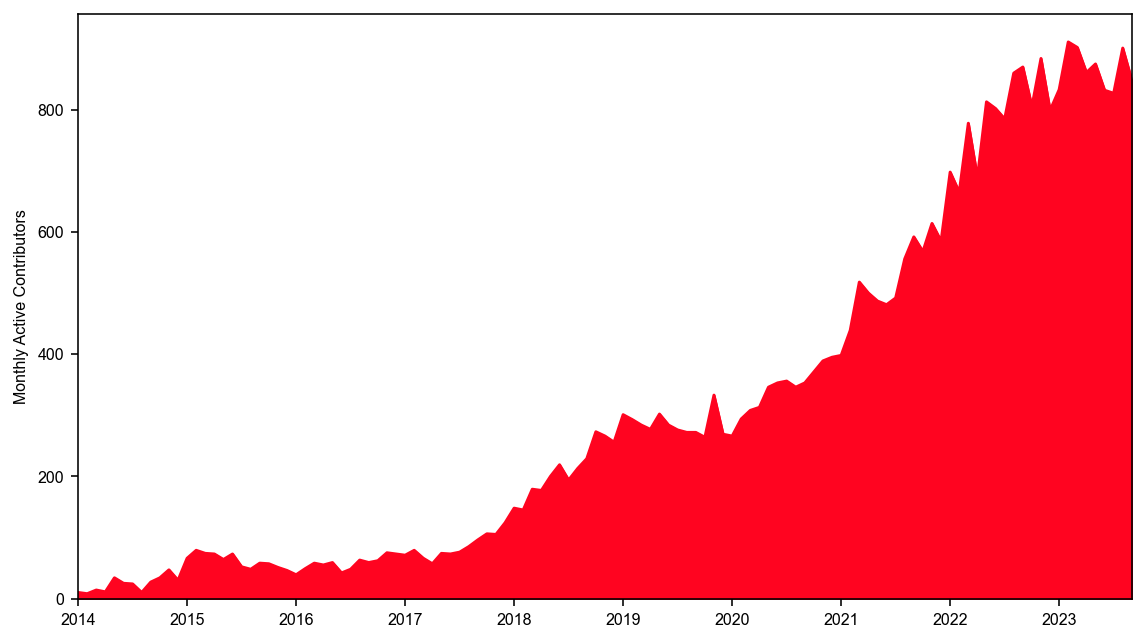

In [19]:
fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
df_contribs[(df_contribs['month']>='2014-01') & (df_contribs['month']<'2023-11')].groupby('month')['sum'].sum().plot(kind='area', ax=ax, color="#FF0420")
ax.set_xlim([0,116])
ax.set_xticks([0,12,24,36,48,60,72,84,96,108])
ax.set_xticklabels(['2014', '2015', '2016', '2017','2018', '2019','2020', '2021', '2022', '2023'])
ax.set_xlabel("")
ax.set_ylabel("Monthly Active Contributors")
fig.tight_layout()

In [20]:
contribution_heatmap(
    df_contribs[(df_contribs['month']>='2014-01') & (df_contribs['month']<'2023-10')], 
    index_col='slug', 
    column_col='month', 
    value_col='sum', 
    sort_label_method='mean',
    cmap='Reds',
    vmax=10,
    #figsize=(32,18)
)

(<Figure size 7020x17820 with 1 Axes>, <AxesSubplot:>)

# Export data for a projects snapshot

In [21]:
query = f"""
   WITH MaxCounts AS (
        SELECT
            p.slug AS slug,
            MAX(CASE WHEN e."typeId" = 14 THEN e.amount END) AS max_stars,
            MAX(CASE WHEN e."typeId" = 22 THEN e.amount END) AS max_forks
        FROM project p
        JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
        LEFT JOIN event e ON e."toId" = paa."artifactId"
        WHERE e."typeId" IN (14, 22)
        GROUP BY p.slug
    )
    , SumCounts AS (
        SELECT
            slug,
            SUM(max_stars) AS total_stars,
            SUM(max_forks) AS total_forks
        FROM MaxCounts
        GROUP BY slug
    )
    , EventStats AS (
        SELECT
            p.slug AS slug,
            MIN(CASE WHEN e."typeId" = 2 THEN e."time" END) AS first_PR,
            MIN(CASE WHEN e."typeId" = 25 THEN e."time" END) AS first_txn,
            COUNT(DISTINCT CASE WHEN e."typeId" = 25 THEN e."fromId" END) AS unique_users,
            SUM(CASE WHEN e."typeId" = 9 THEN e."amount" END) AS total_downloads
        FROM project p
        JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
        LEFT JOIN event e ON e."toId" = paa."artifactId"        
        WHERE e."typeId" IN (2, 25, 9)
        GROUP BY p.slug
    )
    SELECT 
        p.slug AS project_slug,
        e.first_PR AS "First Pull Request Timestamp",
        e.first_txn AS "First OP Mainnet Txn Timestamp",
        e.unique_users AS "Total Unique Users on OP Mainnet",
        s.total_stars AS "Total Stars Received",
        s.total_forks AS "Total Forks Received",
        e.total_downloads AS "Total NPM Downloads"
    FROM project p
    LEFT JOIN EventStats e ON p.slug = e.slug
    LEFT JOIN SumCounts s ON p.slug = s.slug
    WHERE p.slug IN ({slugs_param});
"""

results = execute_query(query)
df_stats = pd.DataFrame(results[1:], columns=results[0]).set_index('project_slug')

In [22]:
# check for possible coverage gaps (there are some known issues)

df_stats[df_stats['Total Stars Received'].isna()==True].sort_values(by='First Pull Request Timestamp').head(20)

First Pull Request Timestamp  \
project_slug                                             
waffle-truefieng             2018-08-23 13:09:07+00:00   
commons-stack                2019-04-04 12:22:59+00:00   
hausdao                      2019-08-24 10:54:25+00:00   
tokenengineeringcommunity    2019-10-20 10:25:52+00:00   
endaoment                    2020-06-18 15:27:08+00:00   
boardroom-inc                2021-01-07 12:24:49+00:00   
coordinape                   2021-03-10 01:45:04+00:00   
withtally                    2021-03-15 14:01:04+00:00   
seedle-finance               2021-05-26 18:19:25+00:00   
dappradar                    2021-06-30 07:01:24+00:00   
rust-kzg-sifraitech          2021-09-28 17:05:34+00:00   
uniwhales                    2021-10-13 22:20:10+00:00   
bootnodedev                  2021-10-14 12:25:30+00:00   
ether-actor-iainnash         2021-11-10 06:40:48+00:00   
hedgey-finance               2021-12-07 02:17:24+00:00   
metricsdao                   2021-12-18 00:25:06+00:00   
blockhead-darryl-yeo         2021-12-24 19:40:36+00:00   
ethereumphone                2021-12-29 03:46:43+00:00   
decentragora                 2022-03-03 01:50:08+00:00   
show-karma                   2022-04-06 19:40:27+00:00   

                          First OP Mainnet Txn Timestamp  \
project_slug                                               
waffle-truefieng                                     NaT   
commons-stack                                        NaT   
hausdao                        2023-10-28 00:00:00+00:00   
tokenengineeringcommunity                            NaT   
endaoment                                            NaT   
boardroom-inc                                        NaT   
coordinape                     2023-06-21 00:00:00+00:00   
withtally                                            NaT   
seedle-finance                                       NaT   
dappradar                                            NaT   
rust-kzg-sifraitech                                  NaT   
uniwhales                                            NaT   
bootnodedev                                          NaT   
ether-actor-iainnash                                 NaT   
hedgey-finance                 2023-11-05 00:00:00+00:00   
metricsdao                                           NaT   
blockhead-darryl-yeo                                 NaT   
ethereumphone                                        NaT   
decentragora                                         NaT   
show-karma                                           NaT   

                           Total Unique Users on OP Mainnet  \
project_slug                                                  
waffle-truefieng                                        0.0   
commons-stack                                           0.0   
hausdao                                                 1.0   
tokenengineeringcommunity                               0.0   
endaoment                                               0.0   
boardroom-inc                                           0.0   
coordinape                                          26164.0   
withtally                                               0.0   
seedle-finance                                          0.0   
dappradar                                               0.0   
rust-kzg-sifraitech                                     0.0   
uniwhales                                               0.0   
bootnodedev                                             0.0   
ether-actor-iainnash                                    0.0   
hedgey-finance                                          1.0   
metricsdao                                              0.0   
blockhead-darryl-yeo                                    0.0   
ethereumphone                                           0.0   
decentragora                                            0.0   
show-karma                                              0.0   

                           Total Stars Re

In [26]:
summary_df = df.join(df_artifact_stats).join(df_stats).sort_index().copy()
summary_df['Avg Monthly Active Devs in 2023'] = avg_active_devs 
summary_df['Avg Monthly Active Contributors in 2023'] = avg_active_contribs

In [27]:
summary_df.iloc[0].T

Project Name                                                                          Splits
Applicant Type                                                                       PROJECT
Payout Address                                    0xe37B8373Fee7e13C2050eA386F3B6e4FE595a7c9
Tags                                       DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_A...
Voting Link                                https://vote.optimism.io/retropgf/3/applicatio...
OSO Link                                       https://opensource.observer/project/0x-splits
RPGF1                                                                                  False
RPGF2                                                                                   True
# GitHub Repos                                                                          15.0
# NPM Packages                                                                           2.0
# OP Multisig Wallets                                                 

In [28]:
summary_df.to_csv(DATA_DIR + "RPGF3_OSO_project_stats_DRAFT.csv")